In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Завантажемо дані з отриманих у `"variable analysis.ipynb"`

In [2]:
rakuten_modified_df = pd.read_excel('rakuten_modified.xlsx', index_col=0)
rakuten_modified_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050 entries, 0 to 1049
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   count_car         1050 non-null   int64         
 1   date              1050 non-null   datetime64[ns]
 2   just_date         1050 non-null   datetime64[ns]
 3   Japan             1050 non-null   int64         
 4   high_temp         1050 non-null   int64         
 5   low_temp          1050 non-null   int64         
 6   rain_probability  1050 non-null   int64         
dtypes: datetime64[ns](2), int64(5)
memory usage: 65.6 KB


# Спробую трансформувати лише колонку з заброньованими авто:

In [31]:
# Залишимо дату замовлення та кількість замовлених авто
df = rakuten_modified_df.set_index('just_date')['count_car'].to_frame()

In [32]:
df.head()

,count_car
just_date,
2016-02-16,1
2016-02-17,0
2016-02-18,0
2016-02-19,1
2016-02-20,2


# Перевірка на стаціонарність

Критерій Дікі-Фуллера: p=0.0137


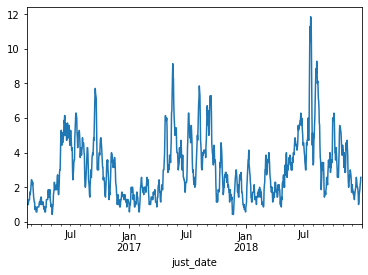

In [7]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Якщо p-value цього критерію менше, ніж 𝛼=0.05, то ряд стаціонарний.
print(f'Критерій Дікі-Фуллера: p={sm.tsa.stattools.adfuller(df)[1]:.4f}')
sm.tsa.seasonal_decompose(df).trend.plot()
plt.show()

# Бокс-Кокс трансформація
### (так як у наших даних присутні нулі ДОДАЄМО одиницю)

In [33]:
from scipy import stats
# from scipy.special import inv_boxcox

f = lambda x: x+1
df['boxcox'], lmbda = stats.boxcox(df.count_car.apply(f))

Критерій Дікі-Фуллера: p=0.0173


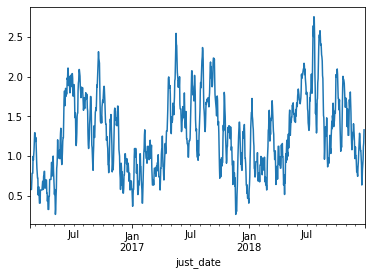

In [11]:
print(f'Критерій Дікі-Фуллера: p={sm.tsa.stattools.adfuller(df.boxcox)[1]:.4f}')
sm.tsa.seasonal_decompose(df.boxcox).trend.plot()
plt.show()

# позбавляємось сезонності

Проведемо сезонне диференціювання. Довжина сезону у нашому випадку дорівнює 12.

Критерий Дики-Фуллера: p-value=0.0000


[]

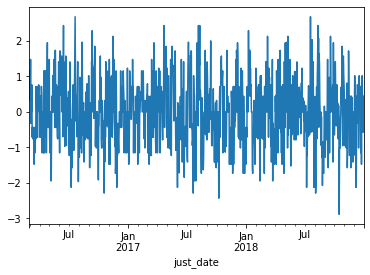

In [34]:
from scipy import stats
# from scipy.special import inv_boxcox

df['boxcox_shifted_S'] = df.boxcox - df.boxcox.shift(12)

p = sm.tsa.stattools.adfuller(df.boxcox_shifted_S[12:])[1]
print(f'Критерій Дікі-Фуллера: p-value={p:.4f}')

df.boxcox_shifted_S[12:].plot()
plt.plot()

# Повернемо предиктори погоди, свят та додамо нові часові:

In [35]:
df[12:]['boxcox_shifted_S']

just_date
2016-02-28    0.762756
2016-02-29    1.155972
2016-03-01    1.155972
2016-03-02    0.440277
2016-03-03    0.322479
                ...   
2018-12-27    0.440277
2018-12-28   -0.578550
2018-12-29   -0.578550
2018-12-30    0.322479
2018-12-31    0.440277
Name: boxcox_shifted_S, Length: 1038, dtype: float64

In [99]:
df_with_predictors = df.merge(rakuten_modified_df, on=['just_date'])


In [100]:
df_with_predictors = df_with_predictors.set_index('just_date')

In [101]:
# Позбудемося зайвих колонок
df_with_predictors = df_with_predictors[12:][['boxcox_shifted_S', 'Japan', 'high_temp', 'low_temp', 'rain_probability']]

In [102]:
df_with_predictors

,boxcox_shifted_S,Japan,high_temp,low_temp,rain_probability
just_date,,,,,
2016-02-28,0.762756,0,26,22,20
2016-02-29,1.155972,0,28,21,20
2016-03-01,1.155972,0,27,22,20
2016-03-02,0.440277,0,27,22,20
2016-03-03,0.322479,0,27,22,20
...,...,...,...,...,...
2018-12-27,0.440277,0,17,13,80
2018-12-28,-0.578550,0,17,13,80
2018-12-29,-0.578550,0,16,12,80


# Додамо предиктори часу:

In [103]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df.pop('date')

    return df


In [104]:
create_features(df_with_predictors)

,boxcox_shifted_S,Japan,high_temp,low_temp,rain_probability,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
just_date,,,,,,,,,,,,
2016-02-28,0.762756,0,26,22,20,6,1,2,2016,59,28,8
2016-02-29,1.155972,0,28,21,20,0,1,2,2016,60,29,9
2016-03-01,1.155972,0,27,22,20,1,1,3,2016,61,1,9
2016-03-02,0.440277,0,27,22,20,2,1,3,2016,62,2,9
2016-03-03,0.322479,0,27,22,20,3,1,3,2016,63,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,0.440277,0,17,13,80,3,4,12,2018,361,27,52
2018-12-28,-0.578550,0,17,13,80,4,4,12,2018,362,28,52
2018-12-29,-0.578550,0,16,12,80,5,4,12,2018,363,29,52


<h1 style='color:red'>Тепер виникло питання, що мені зробити далі?</h1>


* Таким же чином трансформувати інші змінні, чи залишити як є
* Чи провести їх глибокий аналіз, і що б потрібно було зробити?